#Machine Learning Estadístico para Interfaces Cerebro-Computadora

## Trabajo Práctico de Laboratorio de Computación II - Parte II: Filtrado espacial en denoising

Este TPLC tiene como objetivo que el alumno sea capaz de:
1. Afianzar los conocimientos sobre filtrado espacial en el contexto de reparación de artefactos
2. Utilizar y comprender el uso de funciones ya implementadas para realizar denoising en EEG.
3. Comprender la diferencia entre PCA y ICA


Es **requisito** para aprobar este curso que esta guía práctica sea completada y enviada para su evaluación. Se aceptan trabajos realizados en forma grupal de *hasta dos alumnos por grupo*.


❗Antes de comenzar recordá hacer una copia de este documento de manera que puedas editarlo y guardar los cambios en tu Drive.

In [ ]:
# instalamos MNE
!pip install MNE

In [1]:
# importamos las bibliotecas y funciones
import numpy as np
import matplotlib.pyplot as plt
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne import Epochs, pick_types, events_from_annotations
import mne

## PCA + ICA pipeline

A pesasr que PCA y ICA son métodos de filtraod espacial por sí solo que nos permiten encontrar ya sea componentes no-correlacionadas o independientes, respectivamente, en el contexto de las BCI podemos utilizar ambos métodos de manera solidaria a modo de poder encontrar aquellas fuentes relacionadas a artefactos. Es importante mencionar aquí que utilizar PCA y luego ICA es una propuesta metodológica muy utilizada en los problemas llamados "cocktails", en el cual las fuentes deben identificarse de manera separada.

Te podes estar preguntando, porqué es que necesitamos hacer PCA y ICA para denoising. La cosa (explicada rapidito) es que necesitamos recuperar las fuentes originadoras del ruido, las cuales, en el contexto del EEG se suponen independientes y no correlaciondas con la activilidad cerebral. De esta forma, PCA repara el campo de juego para que ICA pueda más facilmente hallar las componentes independientes

### ICA en MNE

MNE tiene una clase super poderosa [ICA](https://mne.tools/stable/generated/mne.preprocessing.ICA.html), cuyo código fuente puede ser un tanto abrumador para principiantes 😬. Pero no te preocupes, acá somos usuarios, y vamos a sacarle todo el juego a esta gran implementación. Creeme, vas a amar la imeplementaci´no de ICA de MNE-Python

En MNE, ICA está implementado como un método de pre-procesamiento para limpieza de artefactos. Como tal, esta clase ya incluye el uso de PCA dentro. Miremos a la siguiente figura que ilustra la filosofía de la implementaicón de ICA:

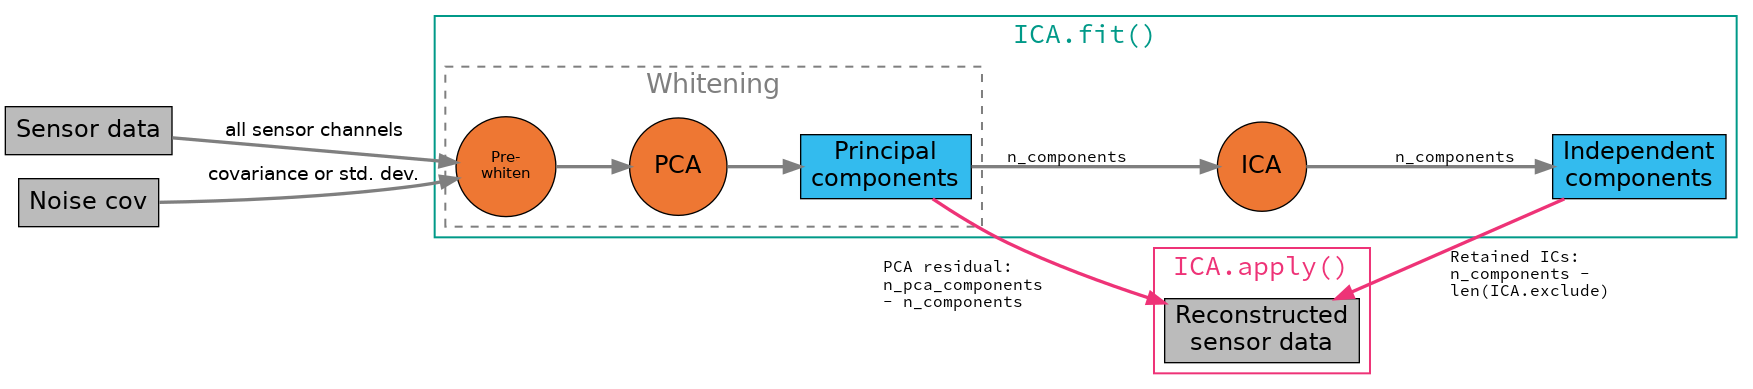

*Figura extraída del tutorial de MNE "[Repairing artifacts with ICA](https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html)"

Como puede ser visto, llamar al método `fit()` de `ICA` realiza un primer lugar whitening. El uso de PCA en este proceso permite además reducir la dimensionalidad del problema. En el espacio de los componentes principales se corre el método ICA propiamente dicho y se encuentran los componentes independientes. Una vez detectado qué y cuáles componentes pertenecen a ruido, se puede pasar a la etapa de recontrucción de la señal. En la clase ICA esto se puede hacer utilizando el método `apply()`
As can be seen, PCA is used for data whitening. It can also be used to reduce the dimensionality of the problem, and thus help ICA in doing it job. Once the independent components are found, the identified artifactual components can be excluded and data can be reconstructed (denoised).

#### Por qué whitening?

Whitening (o blanqueo) es un paso impoetante para ICA, pues las señales se transforman a una espacio **decorrelacionado** y **estandarizado** (desde el punto de vista estadístico). En este sentido, el objetivo principal de aplicar whitening es convertir las señales mezcladas en señales de varianza unitaria no-correlacionadas, de manera de ayudar la identificación de componentes independientes. Esto suena bastante de PCA, no? 😜.

# Los datos

Vamos a utilizar la base de datos de imaginería motora de EEGBCI que utilizamos antes, la cual fue originalmente publicada en [1] y consiste en varios experimentos de BCI realizados a la misma persona. En particular en esta Colab vamos utilizar los datos del sujeto 2 durante las rondas correspondientes a la imaginación del movimiento de mano pies vs manos

In [ ]:
from mne.datasets import eegbci

subject = 2
runs = [6, 10, 14]

raw_fnames = eegbci.load_data(subject, runs)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
eegbci.standardize(raw)
montage = make_standard_montage("standard_1005")
raw.set_montage(montage)

In [ ]:
raw.filter(1.0, 45.0, fir_design="firwin", skip_by_annotation="edge")
tmin, tmax = 0, 4
n_channels = 64
event_id = dict(hand=2, feet=3)
events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

epochs = Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True,
)

❓ ¿Por qué elegimos ese rango de frecuencias? ¿Por qué la época de estudio es más grande que en el TPLC_02a?

Ahora que tenemos las épocas vamos a chusmear un poco las señales que tenemos 👀

In [ ]:
channels_2_plot = ['Fp1', 'Fp2', 'Fz',
                   'O1','Oz','O2',
                   'C1','Cz','C2']
scaling_factor_2_plot = 20e-5
n_epochs_2_plot = 3
epochs.plot(picks=channels_2_plot,n_epochs = n_epochs_2_plot,
            scalings=scaling_factor_2_plot, title="EEG",theme="light",
            show_scrollbars=False);

❓ ¿Qué ves en el EEG? Identificas algo raro?

## Implementando ICA

Estudiamos la clase ICA en MNE 👇

In [ ]:
# Import the ICA object
from mne.preprocessing import ICA

In [ ]:
# See the different attributes of ICA
vars(ICA())

#### Manos a la obra 🤝

1. Instanciá un objeto `ica` en el cuál se extraígan 32 componentes. Para reprocubilidad, ajustá la semilla del método a 73.

In [ ]:
# escribí tú código acá

In [ ]:
# define the ICA object
ica = ICA(...)

2. Utilizá el método .fit() para ajustar el modelo ICA y imprimí en pantalla la dimensión de la matriz de demezcla. ¿Era esperada la dimensión de esta matriz?

💡 TIP: Podes acceder a la matriz de mezcla y de demezcla llamando a los atributos `mixing_matrix_` y `unmixing_matrix_`

In [ ]:
# fit the ICA object

## Visualizando los componentes ICA


Un vez que ajustamos el modelo ICA, hemos entonces hallado la matriz de demezcla. De esta forma, podemos comprender qué tipo de señales se han encontrado. Para ello vamos a visualizar los componentes.

#### Manos a la obra 🤝

1. Utiliza el método `plot_componentes` y el método `plot_sources` para identiicar qué componentes parecen ser de artefacto

💡 TIP: estudiá bien los parámetros de `plot_source`s(). Por estar en una notebook, te recomendamos mirar la señal en una ventana de 5 o 10 seguntos máximo.


In [ ]:
# plot components

In [ ]:
 # Plot sources

2. Definí un arreglo `ica_components_2_analyze` que tenga los índices de los componentes que sospechas son de artefacto. Luego utilizá el método `plot_properties` pasando al parámetro `picks` el arreglo `ica_components_2_analyze`.

In [ ]:
ica_components_2_analyze = ....

In [ ]:
ica.plot_properties(...)

❓ ¿Tenes alguna idea de qué tipo de artefacto pueden ser estas señales?

### The denoising has come 👼

Quizá estemos de acuerdo que los componetes [1,3,7] pueden proveenir de fuentes de ruido. Por lo tanto, si queremos hacer el denoising propiamente dicho, vamos a querer excluir estos componentes al momento de hacer la re-construcción de la señal.

#### Manos a la obra 🤝

1. Definí un arreglo `components_2_exclude` que tenga lo índices de los componentes a excluir, y luego definí el parámetro `exclude` de ica con este arreglo.
2. Realizá el denoising a tus datos utilizando el método `apply`
3. Graficá los datos "limpios". ¿Mejoraron los trazos temporales con respecto a lo que visualizamos antes?

In [ ]:
components_2_exclude = ...
ica.exclude = ...

In [ ]:
# denoise the data
denoised_data =...
print(np.shape(denoised_data))

In [ ]:
channels_2_plot = ['Fp1', 'Fp2', 'Fz',
                   'O1','Oz','O2',
                   'C1','Cz','C2']
scaling_factor_2_plot = 20e-5
n_epochs_2_plot = 3
denoised_data.plot(picks=channels_2_plot,n_epochs = n_epochs_2_plot,
            scalings=scaling_factor_2_plot, title="EEG denoised",theme="light",
                   show_scrollbars=False);
epochs.plot(picks=channels_2_plot,n_epochs = n_epochs_2_plot,
            scalings=scaling_factor_2_plot, title="EEG original",theme="light",
            show_scrollbars=False);

## Análisis de la varianza explicada. Ruido o señal?

Vamos a analizar la propoción de varianza explicada de los datos en diferentes componentes ICA

In [ ]:
ica_components = vector = [i for i in range(ica.n_components)]

¿Qué proporción de la varianza es explicada por los 32 componentes de ICA que extrajimos?

In [ ]:
explained_var_ratio = ica.get_explained_variance_ratio(raw, components = ica_components, ch_type="eeg")
ratio_percent = round(100 * explained_var_ratio["eeg"])

print(
    f"Fraction of variance in EEG signal explained by all components: "
    f"{ratio_percent}%"
)

¿Y para el primer componente?

In [ ]:
explained_var_ratio = ica.get_explained_variance_ratio(raw, components = ica_components[0], ch_type="eeg")
ratio_percent = (100 * explained_var_ratio["eeg"])

print(
    f"Fraction of variance in EEG signal explained by first component: "
    f"{ratio_percent}%"
)


¿Y el segundo?

In [ ]:
explained_var_ratio = ica.get_explained_variance_ratio(raw, components = ica_components[1], ch_type="eeg")
ratio_percent = (100 * explained_var_ratio["eeg"])

print(
    f"Fraction of variance in EEG signal explained by second component: "
    f"{ratio_percent}%"
)

Bueno, como aplica PCA antes de ICA es esperado que los primeros 32 componentes de ICA expliquen la mayoría de la varianza.

❓ Pero, si los datos contienen artefacto, la máxima varianza explicada, a qué está relacionada? ¿Te acordás a qué estaba relacionado el 2do componente en nuestro análisis?

# Para seguir pensando....

❓


1. Puedo aplicar ICA para datos no filtrados?
2. Puedo aplicar ICA en datos no segmentados?
3. Son los componentes hallados realmente independientes?
4. Están ordenados los componentes?



1 ...

2 ...

3 ...

# References
[1] Gerwin Schalk, Dennis J. McFarland, Thilo Hinterberger, Niels Birbaumer, and Jonathan R. Wolpaw. BCI2000: a general-purpose brain-computer interface (BCI) system. IEEE Transactions on Biomedical Engineering, 51(6):1034–1043, 2004. doi:10.1109/TBME.2004.827072.


[2] Pierre Ablin, Jean-Francois Cardoso, and Alexandre Gramfort. Faster Independent Component Analysis by preconditioning with hessian approximations. IEEE Transactions on Signal Processing, 66(15):4040–4049, 2018. doi:10.1109/TSP.2018.2844203.